# Rate Model of 1 Excitatory and 3 Inhibitory populations
4 Wilson-Cowan style populations with feedforward input from thalamus and recurrent connections.

Following the 2 population model in Natan et al 2015, and 4 population model in Litwin-Kumar et al 2016

Rough outline:
0. Make general model with 4x4 weight matrix
1. Set 2 of the I population weights to 0 and reproduce result from Natan

UPDATE: I'm not sure how much it is worth to try to reproduce this network, because it doesn't easily generalize to the Litwin-Kumar 4 population network. There are some weird specificities in here, like the inhibitory transfer function, and the precomputed input current and opto current. One thing that is probably useful is the synaptic adaptiation. So I'm going to skip directly to the Litwin-Kumar network here.

UPDATE 2: the rate network in Litwin-Kumar is the linearized network...

2. DONE - Reproduce steady-state 2 population result from Litwin-Kumar
3. DONE - Reproduce steady-state 4 population result from Litwin-Kumar
4. Add adaptive synapses to recurrent circuit
5. Extend to reproduce experimental findings in Natan, probably need to tile the circuit

In [224]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size']=14
plt.rcParams['font.family']='Arial'

In [312]:
### network architectures
def network(r, t, J, T):    
    drdt = (-r + transfer_func(mu(t) + np.dot(J,r)))/T
    return drdt

def linear_network(r, t, W, T):    
    # linearized network
    # r is a 4-D vector that represents the firing rate of the units
    drdt = (np.dot(W,r)-r + mu(t))/T
    return drdt

def network_TC_adapt(y, t, W, T, T_adapt, g0):
    # network with thalamocortical adaptation
    # y represents the firing rate of the units and the adaptation variables    
    r,g = y[:4], y[4:]
    
    thalamic = generic_constant_input(t, thalamic_drive, thalamic_onset)
    opto = generic_constant_input(t,opto_drive, opto_onset)
    
    # does not depress
#    mu = thalamic + opto
    # depressing synapse
    mu = thalamic*np.hstack((g,[0,0])) + opto
    
    drdt = (np.dot(W,r)-r + mu)/T

    # synaptic adaptation
    # T_g (recovery), T_r (depression)
    r_pre = thalamic[:2]
    T_g, T_r = T_adapt[0,:], T_adapt[1,:]
    dgdt = (g0-g)/T_g - (g*r_pre)/T_r

    dydt = np.hstack((drdt,dgdt))
    return dydt

### transfer functions
def transfer_func(curr_input):
    # transfer function from current to firing rate    
    return curr_input**2

### input functions
def generic_constant_input(t,v=0,t_onset=0.1):
    if t<=t_onset:
        return np.zeros_like(v)
    else:
        return v
    
def mu(t):
    # time-varying input to the network    
    thalamic = generic_constant_input(t,thalamic_drive, thalamic_onset)
    opto = generic_constant_input(t,opto_drive, opto_onset)
    total_drive = thalamic + opto
    return total_drive

### plotting
def plot_rates(t,r,W):    
    c_ord = [0,2,1,4]
    labels = ['E','PV','SOM','VIP']
    plt.subplot(2,1,1)
    for i in range(4):
        plt.plot(t,r[:,i],color=CKEYS[c_ord[i]],label=labels[i])
        
    plt.ylabel('Firing Rate (Hz)')
    plt.legend(); sns.despine()
    
    plt.subplot(2,1,2)
    Ie, Ii = return_EI(r,W)
    plt.plot(t,Ie, 'gray', label='E Total')
    plt.plot(t,Ii, 'k', label='I Total')
    plt.xlabel('Time (s)')
    plt.ylabel('Current')
    plt.legend(); sns.despine()

### analysis
def return_EI(r, W):
    curr = W[0,:]*r
    Ie, Ii=curr[:,0], -curr[:,1:].sum(1)
    return Ie-Ie[0],Ii-Ii[0]

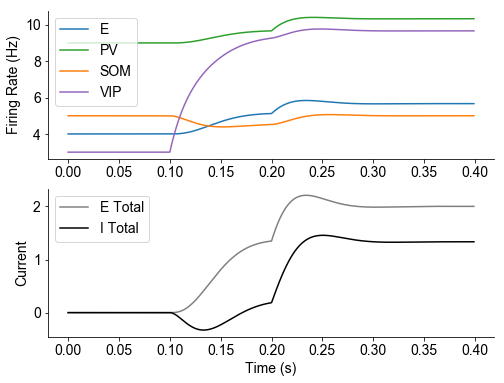

In [295]:
r0 = np.array([4,9,5,3]).T
T, dt = 0.4, 0.001
t = np.arange(0,T,dt)
W_EE = 1.2
W = np.array([[W_EE, -1, -1, 0],
              [1, -1, -0.5, 0],
              [1, 0, 0, -0.25],
              [1, 0, -0.6, 0]])

tau_neurons = np.array([0.02, 0.02, 0.02, 0.02]).T

thalamic_drive = np.array([1,1,0,0]).T
thalamic_onset = 0.2

opto_drive = np.array([0,0,0,5]).T
opto_onset = 0.1


r = integrate.odeint(linear_network, np.zeros(4), t, args=(W, tau_neurons))
plt.figure(figsize=(8,6))
plot_rates(t,r+r0, W)

### Adaptation network

Text(0.5,1,'Adaptation Variables')

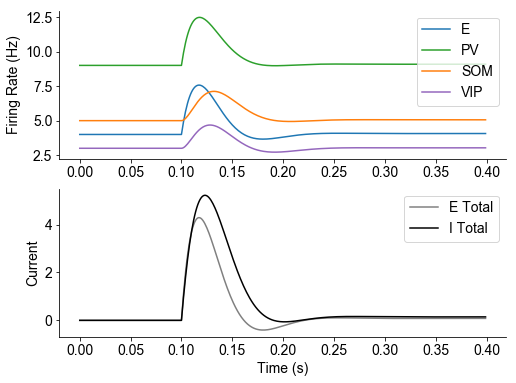

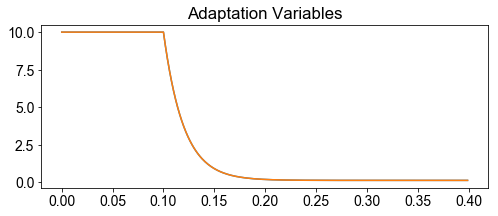

In [323]:
# adaptation variables
T_adapt = np.array([[1.5, 1.5],[0.02, 0.02]])
g0 = np.ones(2)*10

thalamic_drive = np.array([1,1,0,0]).T
thalamic_onset = 0.1
opto_onset = 5

y0 = np.hstack((np.zeros(4),g0))

r = integrate.odeint(network_TC_adapt, y0, t, args=(W, tau_neurons, T_adapt, g0))
plt.figure(figsize=(8,6))
plot_rates(t,r[:,:4]+r0, W)
plt.figure(figsize=(8,3))
plt.plot(t,r[:,4:])
plt.title('Adaptation Variables')